In [1]:
import stable_baselines3 as sb3
from stable_baselines3.ppo import PPO
from stable_baselines3.common.policies import ActorCriticPolicy
from stable_baselines3.common.vec_env.dummy_vec_env import DummyVecEnv
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.env_util import make_vec_env
from typing import Type, Optional, Union, Dict, Any, List, Tuple
import numpy as np
import gymnasium as gym

from dynamic_environments import DynamicFrozenLakeEnv, DynamicEnv

In [2]:
class PolicyAnchoredPPO(PPO):
    """
    Custom PPO class inheriting from Stable Baselines 3 PPO.
    You can add custom logic for the algorithm by modifying this class.
    """

    def __init__(self, 
                 policy: Union[str, Type[ActorCriticPolicy]], 
                 env: Union[DummyVecEnv, str], 
                 gp_threshold: float,  # Default reward threshold for a "good" policy
                 gp_k: int = 5,        # Max number of good policies to store
                 td_alpha: float = 0.5,       # Alpha value for task change detection
                 learning_rate: Union[float, Any] = 3e-4,
                 n_steps: int = 2048,
                 batch_size: int = 64,
                 n_epochs: int = 10,
                 gamma: float = 0.99,
                 gae_lambda: float = 0.95,
                 clip_range: Union[float, Any] = 0.2,
                 ent_coef: float = 0.0,
                 vf_coef: float = 0.5,
                 max_grad_norm: float = 0.5,
                 verbose: int = 0,
                 tensorboard_log: Optional[str] = None,
                 _init_setup_model: bool = True,
                 **kwargs):
        
        # Initialize the parent PPO class
        super(PolicyAnchoredPPO, self).__init__(policy, env, learning_rate=learning_rate, n_steps=n_steps, 
                                        batch_size=batch_size, n_epochs=n_epochs, gamma=gamma,
                                        gae_lambda=gae_lambda, clip_range=clip_range, ent_coef=ent_coef,
                                        vf_coef=vf_coef, max_grad_norm=max_grad_norm,
                                        verbose=verbose, tensorboard_log=tensorboard_log,
                                        _init_setup_model=_init_setup_model, **kwargs)
        
        self.gp_threshold = gp_threshold  # Reward threshold to consider a policy as "good"
        self.gp_k = gp_k                  # Max number of good policies to store
        self.good_policies: List[Tuple[ActorCriticPolicy, float]] = []  # List of (policy, reward)
        self.td_alpha = td_alpha  # Sensitivity parameter for task change detection
        self.previous_rewards = []  # Buffer to store rewards of the previous training step


    def update_good_policies(self, policy: ActorCriticPolicy, reward: float):
        """
        Check if the policy is a 'good' policy based on the reward and update the list.
        """
        if reward >= self.gp_threshold:
            self.good_policies.append((policy, reward))

            # Sort based on rewards in descending order and keep only top k policies
            self.good_policies.sort(key=lambda x: x[1], reverse=True)
            self.good_policies = self.good_policies[:self.gp_k]

    def detect_task_change(self, current_rewards: List[float]):
        """
        Detect if the task/environment has changed based on reward decline.
        A task change is detected if the current rewards are significantly lower
        than the mean of the previous rewards (by alpha times standard deviation).
        """
        if len(self.previous_rewards) == 0:
            # No previous rewards available to compare, skip detection
            return
        
        # Calculate mean and standard deviation of previous rewards
        prev_mean = np.mean(self.previous_rewards)
        prev_std = np.std(self.previous_rewards)

        # Calculate mean of current rewards
        current_mean = np.mean(current_rewards)

        # Check if there's a sharp decline (current rewards < prev_mean - alpha * prev_std)
        if current_mean < (1 - self.td_alpha) * prev_mean  :
            print(f"Task change detected! Current rewards: {current_mean:.2f}, Previous mean: {prev_mean:.2f}, Std: {prev_std:.2f}")

    def _setup_model(self):
        """
        Override to modify model setup if needed.
        """
        super(PolicyAnchoredPPO, self)._setup_model()

    def train(self):
        """
        Overriding the train method to update the 'good' policies at the end of training iterations.
        """
        super(PolicyAnchoredPPO, self).train()

        # Retrieve accumulated rewards after the training step
        if len(self.ep_info_buffer) == 0:
            raise Warning("Cannot find any episode information in the buffer. Make sure you are using a VecEnv.")
        current_rewards = [ep_info['r'] for ep_info in self.ep_info_buffer]
        accumulated_rewards = np.mean(current_rewards)

        # Detect task change based on reward decline
        self.detect_task_change(current_rewards)

        # Store the current rewards for the next step comparison
        self.previous_rewards = current_rewards

        # Update the good policies based on current policy and accumulated rewards
        self.update_good_policies(self.policy, accumulated_rewards)


    def learn(self, total_timesteps: int, callback: Optional[BaseCallback] = None, 
              log_interval: int = 1, tb_log_name: str = "PPO", 
              reset_num_timesteps: bool = True, progress_bar: bool = False):
        """
        Overriding the learn method to track good policies at the end of each iteration.
        """
        return super(PolicyAnchoredPPO, self).learn(total_timesteps=total_timesteps, 
                                            callback=callback, 
                                            log_interval=log_interval, 
                                            tb_log_name=tb_log_name, 
                                            reset_num_timesteps=reset_num_timesteps,
                                            progress_bar=progress_bar)
    
    def get_good_policies(self):
        """
        Get the current list of good policies and their associated rewards.
        """
        return self.good_policies

In [3]:
from stable_baselines3.common.monitor import Monitor, load_results

env = DynamicEnv(switch_after=10000, is_slippery=False)
env = Monitor(env)
# env = make_vec_env(lambda: env, n_envs=1)

model = PolicyAnchoredPPO("MlpPolicy", env, gp_threshold= 1., verbose=1, td_alpha=0.8)

model.learn(total_timesteps=15000)

Using cuda device
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.62     |
|    ep_rew_mean     | 0        |
| time/              |          |
|    fps             | 489      |
|    iterations      | 1        |
|    time_elapsed    | 4        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 7.68         |
|    ep_rew_mean          | 0.01         |
| time/                   |              |
|    fps                  | 392          |
|    iterations           | 2            |
|    time_elapsed         | 10           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0094733145 |
|    clip_fraction        | 0.0337       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.38        |
|    

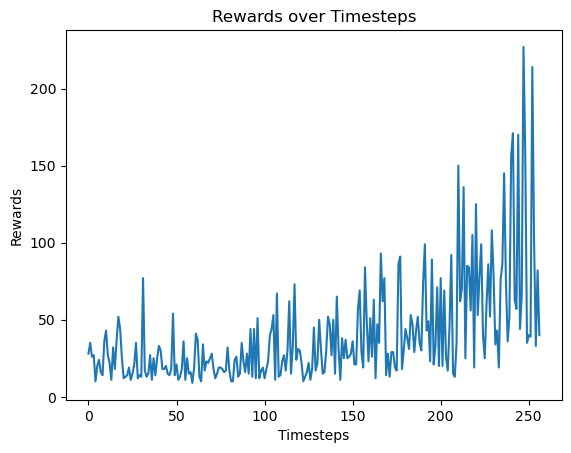

In [26]:
import matplotlib.pyplot as plt
def plotter(env=env, data=None):
    if data is not None:
        plt.plot(data)
    else:
        plt.plot(env.get_episode_rewards())
    plt.xlabel('Timesteps')
    plt.ylabel('Rewards')
    plt.title('Rewards over Timesteps')
    plt.show()

# env = env.get_attr('env')[0]
plotter(env)
# len(env.get_episode_rewards())

In [24]:
# Create environment
env = gym.make('CartPole-v1')
env = Monitor(env)
env = make_vec_env(lambda: env, n_envs=1)

# Create and train the custom PPO model
model = PolicyAnchoredPPO("MlpPolicy", env, gp_threshold= 200, verbose=1)
model.learn(total_timesteps=10000)

# Access the good policies
good_policies = model.get_good_policies()
print(f"Good policies: {good_policies}")

Using cuda device
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 22       |
|    ep_rew_mean     | 22       |
| time/              |          |
|    fps             | 547      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 27.1        |
|    ep_rew_mean          | 27.1        |
| time/                   |             |
|    fps                  | 434         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.008111546 |
|    clip_fraction        | 0.0749      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.687      |
|    explained_variance   | -0.00145    |
|    learnin

In [ ]:
import time
obs = env.reset()
env.render_mode = 'human'
for _ in range(1000):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    time.sleep(0.01)
    env.render()

## Works For Sparse Rewards?? I'm not sure...